<a href="https://colab.research.google.com/github/pooriaazami/deep_learning_class_notebooks/blob/main/18_Cycle_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
from IPython.display import clear_output

In [3]:
files.upload()

clear_output()

In [4]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d balraj98/horse2zebra-dataset

 86% 96.0M/111M [00:00<00:00, 119MB/s]
100% 111M/111M [00:00<00:00, 122MB/s] 


In [6]:
!unzip horse2zebra-dataset.zip
!rm horse2zebra-dataset.zip

clear_output()

In [7]:
!mkdir dataset
!mkdir dataset/test
!mkdir dataset/train

!mv testA dataset/test/horse
!mv testB dataset/test/zebra
!mv trainA dataset/train/horse
!mv trainB dataset/train/zebra

In [8]:
import os
import glob
from functools import partial
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Subset

import torchvision as tv
import torchvision.transforms as T

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [35]:
DATASET_PATH = 'dataset'

BATCH_SIZE = 2
EPOCHS = 1

LR = 2e-4
BETA_1 = .5
BETA_2 = .99

IMAGE_SIZE = 256
SAMPLING_SIZE = 1000

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
class ImageDataset(Dataset):
  def __init__(self, root, label, split, transforms=None):
    super().__init__()

    path = os.path.join(root, split, label)
    assert os.path.isdir(path), f"No such directiry {path}"

    self.images = glob.glob(path + '/*.jpg')
    self.transforms = transforms

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    path = self.images[idx]

    image = Image.open(path).convert('RGB')
    if self.transforms:
      image = self.transforms(image)

    return image

In [37]:
transforms = T.ToTensor()

train_horse_dataset = ImageDataset(DATASET_PATH, 'horse', 'train', transforms=transforms)
train_zebra_dataset = ImageDataset(DATASET_PATH, 'zebra', 'train', transforms=transforms)

test_horse_dataset = ImageDataset(DATASET_PATH, 'horse', 'test', transforms=transforms)
test_zebra_dataset = ImageDataset(DATASET_PATH, 'zebra', 'test', transforms=transforms)

In [38]:
def sample_from_dataset(horse_dataset, zebra_dataset):
  horse_indices = torch.randint(0, len(horse_dataset), size=(SAMPLING_SIZE,))
  zebra_indices = torch.randint(0, len(zebra_dataset), size=(SAMPLING_SIZE,))

  horse_sample = Subset(horse_dataset, horse_indices)
  zebra_sample = Subset(zebra_dataset, zebra_indices)

  return horse_sample, zebra_sample

In [39]:
def get_dataloaders(horse_dataset, zebra_dataset):
  horse_sample, zebra_sample = sample_from_dataset(horse_dataset, zebra_dataset)

  horse_dataloader = DataLoader(horse_sample, batch_size=BATCH_SIZE)
  zebra_dataloader = DataLoader(zebra_sample, batch_size=BATCH_SIZE)

  return horse_dataloader, zebra_dataloader

In [40]:
get_train_dataloader = partial(get_dataloaders,
                               horse_dataset=train_horse_dataset,
                               zebra_dataset=train_zebra_dataset)

get_test_dataloader = partial(get_dataloaders,
                               horse_dataset=test_horse_dataset,
                               zebra_dataset=test_zebra_dataset)

In [41]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, .0, .02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, .2, .02)
    nn.init.constant_(m.bias, 0)

In [42]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv_blocks = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
    )

  def forward(self, x):
    return self.conv_blocks(x)

In [43]:
class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv_blocks = nn.Sequential(
        nn.MaxPool2d(2),
        ConvBlock(in_channels, out_channels).apply(initialize_weights)
    )

  def forward(self, x):
    return self.conv_blocks(x)

In [44]:
class UpBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=2, stride=2).apply(initialize_weights)
    self.conv_blocks = ConvBlock(in_channels, out_channels).apply(initialize_weights)

  def forward(self, x, residual_inputs):
    x = self.up(x)

    diff_y = residual_inputs.size()[2] - x.size()[2]
    diff_x = residual_inputs.size()[3] - x.size()[3]

    x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                  diff_y // 2, diff_y - diff_y // 2])

    x = torch.cat([residual_inputs, x], dim=1)
    x = self.conv_blocks(x)

    return x

In [45]:
class OutBlock(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=num_classes, kernel_size=1).apply(initialize_weights)

  def forward(self, x):
    return self.conv(x)

In [46]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.input_block = ConvBlock(in_channels, 64).apply(initialize_weights)

    self.down_1 = DownBlock(64, 128)
    self.down_2 = DownBlock(128, 256)
    self.down_3 = DownBlock(256, 512)
    self.down_4 = DownBlock(512, 1024)

    self.up_4 = UpBlock(1024, 512)
    self.up_3 = UpBlock(512, 256)
    self.up_2 = UpBlock(256, 128)
    self.up_1 = UpBlock(128, 64)

    self.output_block = OutBlock(64, num_classes)

  def forward(self, x):
    down_cache_1 = self.input_block(x)

    down_cache_2 = self.down_1(down_cache_1)
    down_cache_3 = self.down_2(down_cache_2)
    down_cache_4 = self.down_3(down_cache_3)
    down_cache_5 = self.down_4(down_cache_4)

    x = self.up_4(down_cache_5, down_cache_4)
    x = self.up_3(x, down_cache_3)
    x = self.up_2(x, down_cache_2)
    x = self.up_1(x, down_cache_1)

    x = self.output_block(x)

    return x

In [47]:
class Discriminator(nn.Module):
  def __init__(self, image_edge):
    super().__init__()

    self.layers = nn.Sequential(
        ConvBlock(3, 64),
        DownBlock(64, 128),
        DownBlock(128, 256),
        DownBlock(256, 512),
        DownBlock(512, 512),

        nn.Flatten(1),

        nn.Linear(512 * (image_edge // (2 ** 4)) ** 2, 256),
        nn.ReLU(),
        nn.Linear(256, 1)
    )

  def forward(self, x):
    return self.layers(x)

In [48]:
h2z_gen = UNet(3, 3).to(DEVICE)
z2h_gen = UNet(3, 3).to(DEVICE)

h2z_disc = Discriminator(IMAGE_SIZE).to(DEVICE)
z2h_disc = Discriminator(IMAGE_SIZE).to(DEVICE)

In [49]:
identity_criterion = nn.L1Loss()
gan_criterion = nn.MSELoss()
cycle_criterion = nn.L1Loss()

In [50]:
gen_optimizer = optim.Adam(chain(h2z_gen.parameters(), z2h_gen.parameters()),
                           lr=LR,
                           betas=(BETA_1, BETA_2))

h2z_disc_optimizer = optim.Adam(h2z_disc.parameters(),
                                lr=LR,
                                betas=(BETA_1, BETA_2))

z2h_disc_optimizer = optim.Adam(z2h_disc.parameters(),
                                lr=LR,
                                betas=(BETA_1, BETA_2))

In [51]:
def calculate_identity_loss(h, z):
  # Z2H Gan
  fake_h = z2h_gen(h)
  h_identity_loss = identity_criterion(fake_h, h)

  # H2Z Gan
  fake_z = h2z_gen(z)
  z_identity_loss = identity_criterion(fake_z, z)

  # Total
  identity_loss = .5 * (h_identity_loss + z_identity_loss)

  return identity_loss

In [52]:
def calculate_gan_loss(h, z):
  # Z2H Gan
  fake_h = z2h_gen(z)
  fake_h_preds = z2h_disc(fake_h)
  fake_h_loss = gan_criterion(fake_h_preds, torch.ones_like(fake_h_preds))

  # Z2H Gan
  fake_z = h2z_gen(h)
  fake_z_preds = h2z_disc(fake_z)
  fake_z_loss = gan_criterion(fake_z_preds, torch.ones_like(fake_z_preds))

  # Total
  gan_loss = .5 * (fake_h_loss + fake_z_loss)

  return gan_loss, fake_h, fake_z

In [53]:
def calculate_cycle_loss(h, z, fake_h, fake_z):
  # Z2H Gan
  recovered_h = z2h_gen(fake_z)
  recovered_h_loss = cycle_criterion(recovered_h, h)

  # H2Z Gan
  recovered_z = h2z_gen(fake_h)
  recovered_z_loss = cycle_criterion(recovered_z, z)

  # Total
  cycle_loss = .5 * (recovered_h_loss + recovered_z_loss)

  return cycle_loss

In [54]:
def calculate_h_disc_loss(h, z):
  # Fake
  fake_h = z2h_gen(z)
  fake_preds = z2h_disc(fake_h)
  fake_loss = gan_criterion(fake_preds, torch.zeros_like(fake_preds))

  # Real
  real_preds = z2h_disc(h)
  real_loss = gan_criterion(real_preds, torch.ones_like(real_preds))

  # Total
  loss = .5 * (fake_loss + real_loss)

  return loss

In [55]:
def calculate_z_disc_loss(h, z):
  # Fake
  fake_z = h2z_gen(h)
  fake_preds = h2z_disc(fake_z)
  fake_loss = gan_criterion(fake_preds, torch.zeros_like(fake_preds))

  # Real
  real_preds = h2z_disc(z)
  real_loss = gan_criterion(real_preds, torch.ones_like(real_preds))

  # Total
  loss = .5 * (fake_loss + real_loss)

  return loss

In [56]:
def train_gen(h, z):
  gen_optimizer.zero_grad()

  identity_loss = calculate_identity_loss(h, z)
  gen_loss, fake_h, fake_z = calculate_gan_loss(h, z)
  cycle_loss = calculate_cycle_loss(h, z, fake_h, fake_z)

  total_loss = identity_loss + gen_loss + cycle_loss
  total_loss.backward()

  gen_optimizer.step()

  return identity_loss.detach().cpu().item(), gen_loss.detach().cpu().item(), cycle_loss.detach().cpu().item()

In [57]:
def train_discs(h, z):
  # h2z Disc
  h2z_disc_optimizer.zero_grad()

  h2z_loss = calculate_z_disc_loss(h, z)
  h2z_loss.backward()

  h2z_disc_optimizer.step()

  # z2h Disc
  z2h_disc_optimizer.zero_grad()

  z2h_loss = calculate_h_disc_loss(h, z)
  z2h_loss.backward()

  z2h_disc_optimizer.step()

  return h2z_loss.detach().cpu().item(), z2h_loss.detach().cpu().item()

In [58]:
total_identity_loss, total_gen_loss, total_cycle_loss, total_h2z_loss, total_z2h_loss = [.0 for i in range(5)]

In [59]:
identity_loss_log, gen_loss_log, cycle_loss_log, h2z_loss_log, z2h_loss_log = [], [], [], [] ,[]

In [60]:
for epoch in range(1, EPOCHS + 1):
  total_identity_loss, total_gen_loss, total_cycle_loss, total_h2z_loss, total_z2h_loss = [.0 for i in range(5)]
  print(f'Epoch {epoch} / {EPOCHS}')

  h_dataloader, z_dataloader = get_train_dataloader()

  for h, z in zip(tqdm(h_dataloader), z_dataloader):
    h = h.to(DEVICE)
    z = z.to(DEVICE)

    identity_loss, gen_loss, cycle_loss = train_gen(h, z)
    h2z_loss, z2h_loss = train_discs(h, z)

    total_identity_loss += identity_loss
    total_gen_loss += gen_loss
    total_cycle_loss += cycle_loss
    total_h2z_loss += h2z_loss
    total_z2h_loss += z2h_loss

  identity_loss_log.append(total_identity_loss)
  gen_loss_log.append(total_gen_loss)
  cycle_loss_log.append(total_cycle_loss)
  h2z_loss_log.append(total_h2z_loss)
  z2h_loss_log.append(total_z2h_loss)

Epoch 1 / 1


  0%|          | 0/500 [00:00<?, ?it/s]

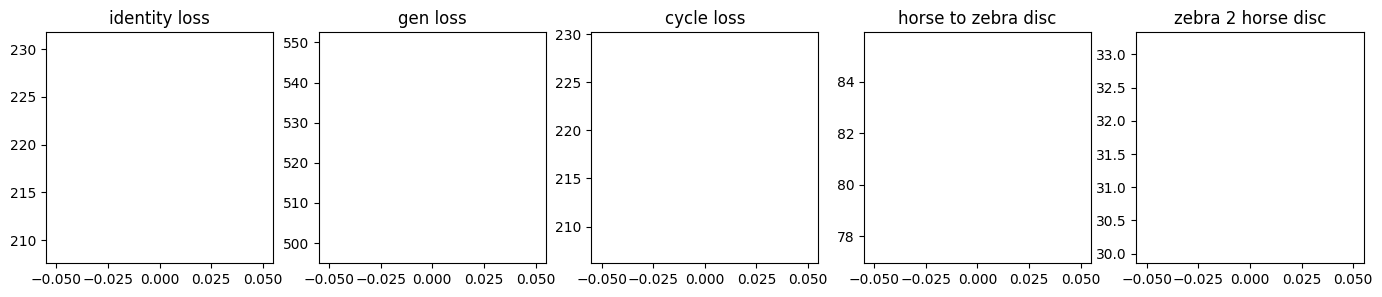

In [61]:
fig, axs = plt.subplots(1, 5, figsize=(17, 3))

axs[0].plot(identity_loss_log)
axs[0].set_title('identity loss')

axs[1].plot(gen_loss_log)
axs[1].set_title('gen loss')

axs[2].plot(cycle_loss_log)
axs[2].set_title('cycle loss')

axs[3].plot(h2z_loss_log)
axs[3].set_title('horse to zebra disc')

axs[4].plot(z2h_loss_log)
axs[4].set_title('zebra 2 horse disc')

plt.show()

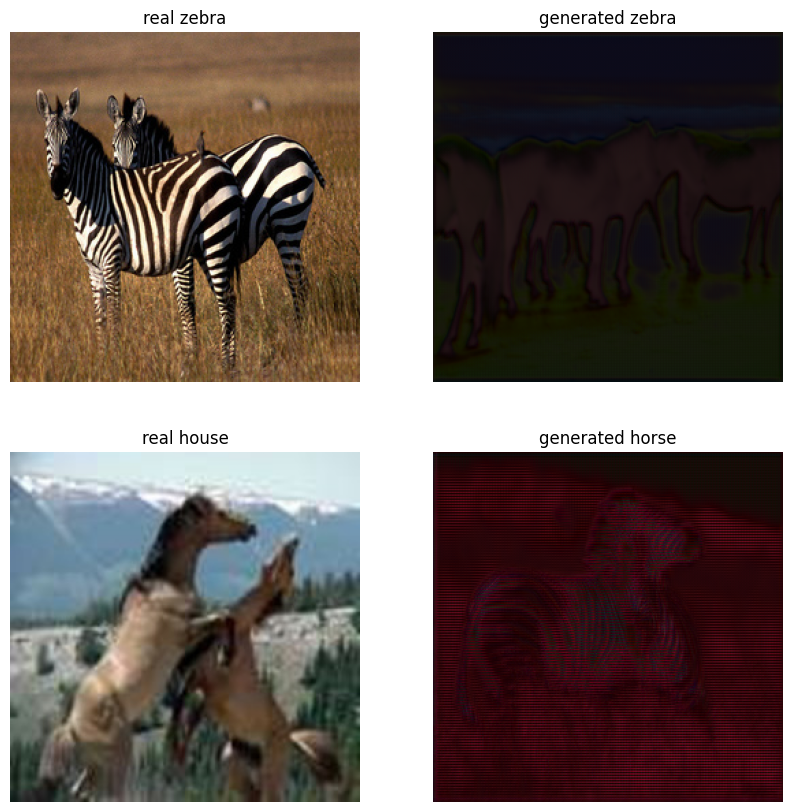

In [64]:
with torch.no_grad():
  horse_dataloader, zebra_dataloader = get_test_dataloader()

  for h, z in zip(horse_dataloader, zebra_dataloader):
    h = h.to(DEVICE)
    z = z.to(DEVICE)


    fake_z = h2z_gen(h).cpu().numpy()
    fake_h = z2h_gen(z).cpu().numpy()

    z = z.cpu().numpy()
    h = h.cpu().numpy()
    break

  fig, axs = plt.subplots(2, 2, figsize=(10, 10))

  axs[0][0].imshow(z[0].transpose((1, 2, 0)))
  axs[0][0].set_title('real zebra')
  axs[0][0].axis('off')

  axs[0][1].imshow(fake_z[1].transpose((1, 2, 0)))
  axs[0][1].set_title('generated zebra')
  axs[0][1].axis('off')

  axs[1][0].imshow(h[0].transpose((1, 2, 0)))
  axs[1][0].set_title('real house')
  axs[1][0].axis('off')

  axs[1][1].imshow(fake_h[1].transpose((1, 2, 0)))
  axs[1][1].set_title('generated horse')
  axs[1][1].axis('off')

  plt.show()
